In [14]:
# Install dependencies
!pip install -q torch torchvision transformers pillow matplotlib

In [15]:
# Imports
import torch
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2  # Import OpenCV for resizing masks

In [16]:
# Load Model & Processor
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to(device)

In [17]:
# Load Image (New URL)
image_url = "https://images.pexels.com/photos/378570/pexels-photo-378570.jpeg"  # City skyline at night
response = requests.get(image_url, stream=True)

if response.status_code == 200:
    image = Image.open(response.raw)
else:
    raise ValueError("Error: Unable to fetch the image. Check the URL.")

In [18]:
# Convert PIL image to NumPy array
image_np = np.array(image)

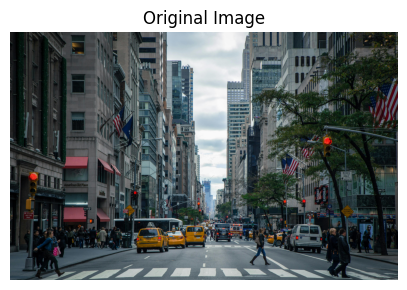

In [19]:
# Display the original image
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.title("Original Image")
plt.show()


In [20]:
# Define Prompts (New Object Categories)
prompts = ["skyscrapers", "water reflection", "clouds", "lights"]

In [21]:
# Process the image and prompts
inputs = processor(
    text=prompts,
    images=[image] * len(prompts),  # Repeat the image for each prompt
    return_tensors="pt",
    padding="max_length"
).to(device)

# Run the model for segmentation
with torch.no_grad():
    outputs = model(**inputs)

In [22]:
# Get predictions
masks = outputs.logits.sigmoid().cpu().numpy()

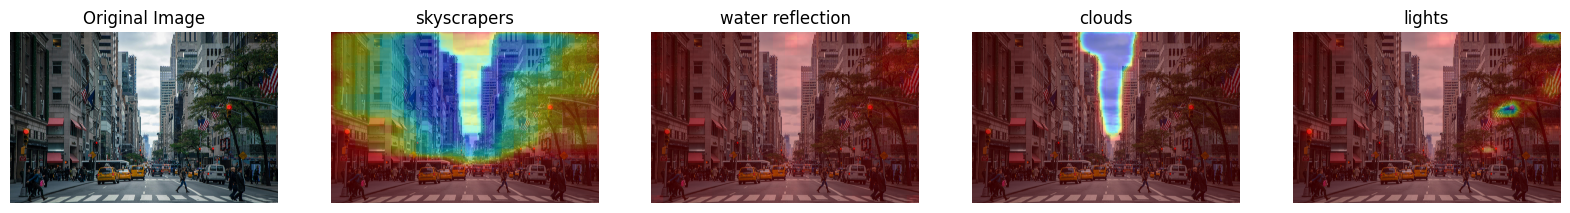

In [23]:
# Visualization
fig, axes = plt.subplots(1, len(prompts) + 1, figsize=(4 * (len(prompts) + 1), 5))

# Show original image
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Show segmented images
for i, (mask, prompt) in enumerate(zip(masks, prompts)):
    # Resize the mask to match the original image dimensions
    mask_resized = cv2.resize(mask, (image_np.shape[1], image_np.shape[0]))

    # Normalize the mask
    mask_resized = (mask_resized - mask_resized.min()) / (mask_resized.max() - mask_resized.min())

    # Convert mask to heatmap
    heatmap = cv2.applyColorMap((mask_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)

    # Blend the heatmap with the original image
    overlay = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

    # Display the segmented image
    axes[i + 1].imshow(overlay)
    axes[i + 1].set_title(prompt)
    axes[i + 1].axis("off")

# Show the plot
plt.show()